This Notebook shows how to optimise the pruning parameters of your network based on pairwise connectivity data.

First we need to create a small network that we can use for the optimisation of the pruning parameters.

In this example we do not need to have realistic neuron densities, so we will place the neurons in a cube of diameter 100 micrometers.

In [1]:
import os

n_neurons = 100
# pop_size = 10
# epochs = 10

pre_type = "iSPN"
post_type = "iSPN"
con_type = "GABA"

network_path = os.path.join("networks", f"{pre_type}_to_{post_type}")

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
extra_pruning_parameters = { 'distPruning': SPN2SPNdistDepPruning }

all_experimental_data = {}
all_experimental_data["dSPN", "iSPN"] = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
all_experimental_data["dSPN", "dSPN"] = [(0, 50e-6, 5/19.0), (0, 100e-6, 3/43.0)]
all_experimental_data["iSPN", "iSPN"] = [(0, 50e-6, 14/39.0), (0, 100e-6, 7/31.0)]
all_experimental_data["iSPN", "dSPN"] = [(0, 50e-6, 13/47.0), (0, 100e-6, 10/80.0)]

experimental_data = all_experimental_data[pre_type, post_type]
avg_num_synapses_per_pair = 3  # Expected mean, error weight

In [2]:
from snudda.place.create_cube_mesh import create_cube_mesh

mesh_file = os.path.join(network_path, "cube-mesh.obj")
create_cube_mesh(mesh_file, [0,0,0], 120e-6)

from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123, snudda_data="../../../../BasalGangliaData/data/")

si.define_structure(struct_name="Cube", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)

if pre_type == post_type:
    si.add_neurons(name=pre_type, num_neurons=n_neurons, volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
else:
    si.add_neurons(name=pre_type, num_neurons=int(n_neurons/2), volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
    si.add_neurons(name=post_type, num_neurons=int(n_neurons/2), volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
    

# The parameters here does not matter, they will be set during optimisation
si.add_neuron_target(neuron_name=pre_type,
                     target_name=post_type,
                     connection_type=con_type,
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=None, soft_max=None, mu2=None,
                     a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     mod_file="tmGabaA")

si.write_json()

Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Writing networks/iSPN_to_iSPN/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/iSPN_to_iSPN/network-config.json


Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/iSPN_to_iSPN/network-config.json


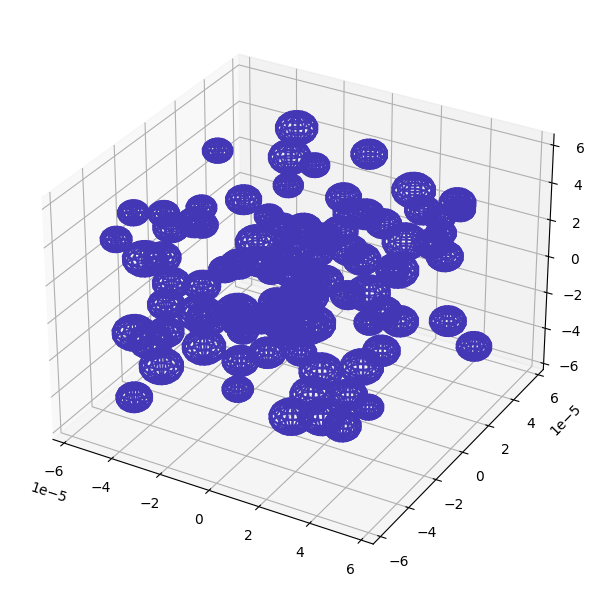

In [4]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100)
sd.detect()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/iSPN_to_iSPN/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 31/125 (100 neurons)
Processing hyper voxel : 56/125 (100 neurons)
Processing hyper voxel : 32/125 (99 neurons)
Processing hyper voxel : 57/125 (97 neurons)
Processing hyper voxel : 36/125 (92 neurons)
Processing hyper voxel : 61/125 (90 neurons)
Processing hyper voxel : 37/125 (80 neurons)
Processing hyper voxel : 62/125 (66 neurons)
Processing hyper voxel : 26/125 (46 neurons)
Processing hyper voxel : 51/125 (43 neurons)
Processing hyper voxel : 30/125 (37 neurons)
Processing hyper voxel : 27/125 (30 neurons)
Processing hyper voxel : 55/125 (29 neurons)
Processing hyper voxel : 52/125 (26 neurons)
Processing hyper voxel : 6/125 (22 neurons)
Processing hyper voxel : 35/125 (21 neurons)
Processing hyper voxel : 60/125 (15 neurons)
Processing hyper voxel : 81/125 (13 neurons)
Processing hyper voxel : 11/1

In [6]:
from snudda.optimise.optimise_pruning import OptimisePruning
op = OptimisePruning(network_path=network_path)

In [7]:
op.merge_putative_synapses(force_merge=True)

Read 177639 out of total 177639 synapses


In [8]:
op.prune.connectivity_distributions

{(1,
  1,
  10): (OrderedDict([('f1', 1.0),
               ('softMax', None),
               ('mu2', None),
               ('a3', None),
               ('distPruning', '1-exp(-(0.4*d/60e-6)**2)'),
               ('cluster', False)]), None)}

In [9]:
op.prune.type_id_lookup

{'iSPN': 1}

In [10]:
op.prune.hist_file["meta/connectivityDistributions"][()]

b'{"iSPN$$iSPN": {"GABA": {"conductance": [2.4e-10, 1e-10], "channelParameters": {"modFile": "tmGabaA"}, "clusterSize": 1, "clusterSpread": null, "pruning": {"f1": null, "softMax": null, "mu2": null, "a3": null, "distPruning": "1-exp(-(0.4*d/60e-6)**2)", "cluster": false}, "channelModelID": 10, "lognormal_mu_sigma": [-22.230424900260093, 0.40010675493807013]}}}'

In [11]:
res = op.optimize(pre_type=pre_type, post_type=post_type, con_type=con_type, 
                  experimental_data=experimental_data, 
                  avg_num_synapses_per_pair=avg_num_synapses_per_pair,
                  extra_pruning_parameters=extra_pruning_parameters, 
                  workers=8, maxiter=1000, tol=0.0001)

/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:377: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Worker iter: 100, fitness 10.810641623404253
Worker iter: 100, fitness 10.855198231131151
Worker iter: 100, fitness 10.264840394826306
Worker iter: 100, fitness 10.40647853866888
Worker iter: 100, fitness 10.749698238079594
Worker iter: 100, fitness 10.601700940765276
Worker iter: 100, fitness 10.413376832756342
Worker iter: 100, fitness 10.378239650995784
Worker iter: 200, fitness 10.044262819876499
Worker iter: 200, fitness 10.145282917637726
Worker iter: 200, fitness 10.069955121575347
Worker iter: 200, fitness 10.036449134129773
Worker iter: 200, fitness 10.076949972127391
Worker iter: 200, fitness 10.059267272277518
Worker iter: 200, fitness 10.03411082058948
Worker iter: 200, fitness 10.018300361251345
Worker iter: 300, fitness 9.978279420332822
Worker iter: 300, fitness 9.955613789835224
Worker iter: 300, fitness 9.955605730727745
Worker iter: 300, fitness 9.934915999836258
Worker iter: 300, fitness 9.902022227376762
Worker iter: 300, fitness 9.94747199499301
Worker iter: 300, f

# Best parameter set

In [24]:
print(f"f1 = %f, softMax = %f, mu2 = %f, a3 = %f" % (res.x[0], res.x[1], res.x[2], res.x[3]))

f1 = 0.281247, softMax = 14.757355, mu2 = 1.292919, a3 = 0.625306


In [34]:
res

     fun: 9.87475975159576
 message: 'Optimization terminated successfully.'
    nfev: 6245
     nit: 103
 success: True
       x: array([ 0.28124667, 14.75735518,  1.29291887,  0.62530621])

In [25]:
import os
from snudda.analyse.analyse import SnuddaAnalyse
import glob

# Get the last file
list_of_files = glob.glob(os.path.join(network_path, "temp", "network-synapses-*hdf5"))
network_file = max(list_of_files, key=os.path.getctime)

dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Number of neurons: 100
Synapse row 0 - 0.0 % time: 0.00017845899856183678 seconds
Created connection matrix 0.00866832800238626 seconds
Created gap junction connection matrix 9.433399827685207e-05 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 8528, at 0
Created distance histogram (optimised) in 0.0071714459991198964 seconds
Saving cache to networks/iSPN_to_iSPN/temp/network-synapses-7dab0eb5-506a-4b69-9c1b-e3cafb8167aa.hdf5-cache


In [26]:
sa.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)])

Missing dSPN or iSPN in network, skipping plot with their connectivity


In [27]:
sa.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)])

Missing dSPN or dSPN in network, skipping plot with their connectivity


Plotting connection probability iSPN to iSPN (synapses)
Centering in None : Keeping 100/100
Counting connections
Requested: 10000000.0 calculated [9900.]
P(d<5e-05) = 0.3250117757889779
P(d<0.0001) = 0.2931175747644408


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1380: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


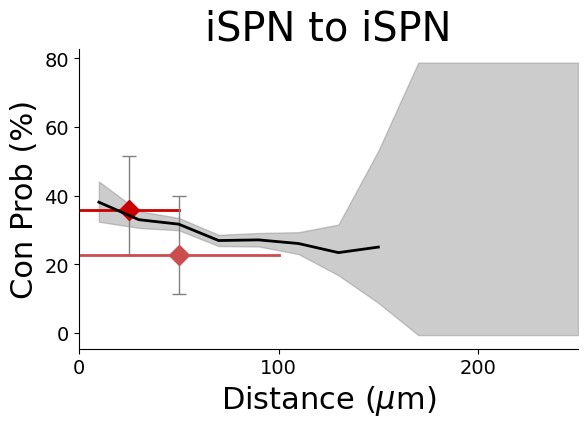

Wrote networks/iSPN_to_iSPN/temp/figures/Network-distance-dependent-connection-probability-iSPN-to-iSPN-synapses-3D-dist.pdf


({5e-05: 0.3250117757889779, 0.0001: 0.2931175747644408},
 'networks/iSPN_to_iSPN/temp/figures/Network-distance-dependent-connection-probability-iSPN-to-iSPN-synapses-3D-dist.pdf')

In [28]:
sa.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)])

In [29]:
sa.plot_connection_probability("iSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(13, 47), (10, 80)])

Missing iSPN or dSPN in network, skipping plot with their connectivity


In [30]:
sa.plot_num_synapses_per_pair("dSPN", "iSPN")

Plotting number of connections
plotNumSynapsesPerPair: dSPN is not in the simulation


In [31]:
sa.plot_num_synapses_per_pair("dSPN", "dSPN")

Plotting number of connections
plotNumSynapsesPerPair: dSPN is not in the simulation


Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 100/100
Calculating max synapses
Calculating mean synapses
Plotting 2894 connections


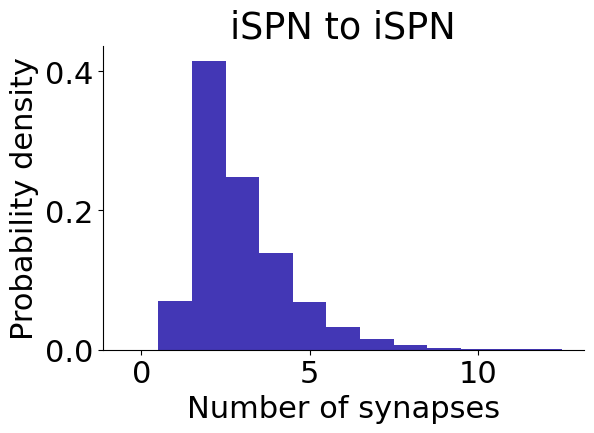

Wrote networks/iSPN_to_iSPN/temp/figures/Network-number-of-synapses-from-iSPN-to-iSPN-per-cell.pdf


In [32]:
sa.plot_num_synapses_per_pair("iSPN", "iSPN")

In [33]:
sa.plot_num_synapses_per_pair("dSPN", "dSPN")

Plotting number of connections
plotNumSynapsesPerPair: dSPN is not in the simulation
